# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
beta = pd.read_csv('/datasets/Churn.csv')
beta.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
beta.shape

(10000, 14)

In [5]:
beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Сразу заметны пропуски в столбце Tenure. Так как значения в этом столбце описывают то, сколько лет человек был клиентом банка, то здесь скорее эти пропуски могут указывать на то, что клиент сотрудничает с банком менее года, поэтому эти значения можно заменить на нули.

Также в датафрейме присутствуют данные, которые не пригодятся нам для дальнейшего анализа. Столбцы RowNumber, CustomerId, Surname можно будет удалить.

In [6]:
beta['Tenure'] = beta['Tenure'].fillna(0)
beta['Tenure'].isnull().sum()

0

In [7]:
beta.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [8]:
beta.duplicated().sum()

0

In [9]:
beta.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим, в каком соотношений присутсвуют значения в целевом признаке Exited:

In [10]:
class_frequency = beta['Exited'].value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Значения 0 ≈80% , 1 ≈ 20%. В дальнейшем необходимо будет сбалансировать классы

Проверка уникальных значений в категориальных признаках Geography и Gender:

In [11]:
beta['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [12]:
beta['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Теперь преобразуем категориальные признаки в численные с помощью техники OHE 

In [13]:
beta_ohe = pd.get_dummies(beta, drop_first=True)
beta_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [14]:
beta_ohe.shape

(10000, 12)

## Исследование задачи

In [15]:
# Деление на тестовый и обучающий наборы
beta_train, beta_test = train_test_split(beta_ohe, test_size=0.4, random_state=12345)

# Объявим две переменные features и target. 
# В target укажем целевой признак Exited, в features сохраним все признаки за исключением целевого
target = beta_test['Exited']
features = beta_test.drop('Exited', axis=1)

# Теперь разделим тестовую выборку на тестовую и валидационную
features_valid,features_test,target_valid,target_test = train_test_split(features,target,
                                                                test_size=0.5,random_state=12345)
features_train = beta_train.drop('Exited', axis=1)
target_train = beta_train['Exited']

print(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11) (2000,) (2000, 11) (2000,)


Далее приведем признаки к одному масштабу, так мы сделаем все признаки одинаково значимыми. Воспользуемся структурой для стандартизации данных — StandardScaler

In [16]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
pd.options.mode.chained_assignment = None
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [18]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


In [19]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-0.825373,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.503694,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.468729,0.438711,-0.891560,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.748053,1.239884,-0.891560,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.748053,-1.233163,0.830152,1,0,1.358533,0,1,1


In [20]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-0.825373,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.426375,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.139662,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.748053,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.748053,0.615625,-0.891560,0,1,-1.070919,0,0,1


Перейдем к исследованию моделей LogisticRegression и RandomForestRegressor

LogisticRegression

In [21]:
model_LR = LogisticRegression(random_state = 125, solver = 'liblinear')
model_LR.fit(features_train, target_train)
prediction_LR = model_LR.predict(features_valid)

print("Точность для LogisticRegression:", accuracy_score(target_valid, prediction_LR))
print("F1 для LogisticRegression:", f1_score(prediction_LR, target_valid))

Точность для LogisticRegression: 0.8025
F1 для LogisticRegression: 0.33389544688026984


RandomForestClassifier

In [22]:
model_RFC = RandomForestClassifier(random_state=125, n_estimators=100,max_depth= 14)
model_RFC.fit(features_train, target_train)
prediction_RFC = model_RFC.predict(features_valid)

print("Точность для RandomForestClassifier:", accuracy_score(target_valid, prediction_RFC))
print("F1 для RandomForestClassifier:", f1_score(prediction_RFC, target_valid))

Точность для RandomForestClassifier: 0.8635
F1 для RandomForestClassifier: 0.5894736842105264


In [23]:
from tqdm.notebook import tqdm

In [24]:
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 250, 25), desc="Est loop"):
    for depth in tqdm(range (1, 15, 2), desc="Depth loop", leave=False):
        model_RFC = RandomForestClassifier(random_state=125, max_depth=depth, n_estimators=est) 
        model_RFC.fit(features_train, target_train) 
        prediction_RFC = model_RFC.predict(features_valid)
        f1 = f1_score(prediction_RFC, target_valid)
        
        if f1 > best_result:
            best_result = f1
            best_est = est
            best_depth = depth
            
print("F1-мера наилучшей модели:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)


F1-мера наилучшей модели: 0.5840978593272171
Количество деревьев: 135
Максимальная глубина: 11


In [25]:
model_RFC = RandomForestClassifier(random_state=125, n_estimators=best_est,max_depth= best_depth)
model_RFC.fit(features_train, target_train)
prediction_RFC = model_RFC.predict(features_valid)

print("Точность для RandomForestClassifier:", accuracy_score(target_valid, prediction_RFC))

Точность для RandomForestClassifier: 0.864


## Борьба с дисбалансом

In [26]:
target_train.value_counts(normalize = 1)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

In [27]:
target_valid.value_counts(normalize = 1)

0    0.791
1    0.209
Name: Exited, dtype: float64

Вес класса "0" больше веса класса "1" в соотношении 4:1.

Сделаем веса классов сбалансированными, добавив к моделям аргумент class_weight='balanced' и проверим значение точности и F1 меры:

In [28]:
model_LR = LogisticRegression(random_state = 125, solver = 'liblinear', class_weight='balanced')
model_LR.fit(features_train, target_train)
prediction_LR = model_LR.predict(features_valid)

print("Точность для LogisticRegression:", accuracy_score(target_valid, prediction_LR))
print("F1 для LogisticRegression:", f1_score(prediction_LR, target_valid))

Точность для LogisticRegression: 0.701
F1 для LogisticRegression: 0.4888888888888888


In [29]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 250, 25), desc="Est loop"):
    for depth in tqdm(range (1, 15, 2), desc="Depth loop", leave=False):
        model_RFC = RandomForestClassifier(random_state=125, max_depth=depth, n_estimators=est, class_weight='balanced') 
        model_RFC.fit(features_train, target_train) 
        prediction_RFC = model_RFC.predict(features_valid)
        f1 = f1_score(prediction_RFC, target_valid)
        
        if f1 > best_result:
            best_result = f1
            best_est = est
            best_depth = depth
            best_model = model_RFC
            
print("F1-мера наилучшей модели:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)
print("Наилучшая модель:", best_model)


F1-мера наилучшей модели: 0.6291179596174282
Количество деревьев: 210
Максимальная глубина: 7
Наилучшая модель: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=210, n_jobs=None, oob_score=False,
                       random_state=125, verbose=0, warm_start=False)


In [30]:
model_RFC = best_model
model_RFC.fit(features_train, target_train)
prediction_RFC = model_RFC.predict(features_valid)

print("Точность для RandomForestClassifier:", accuracy_score(target_valid, prediction_RFC))

Точность для RandomForestClassifier: 0.8255


- Значение F1 меры для LogisticRegression увеличилось с 0.33 до 0.49, но accuracy снизилось с 0.8 до 0.7, зато теперь мы имеем дело с более точными характеристиками
- Для RandomForestClassifier значение accuracy значение стало равным 0.82, а F1 мера также увеличилась с 0.58 до 0.63

Построим матрицу ошибок для наших моделей:

LogisticRegression

In [31]:
model_LR = LogisticRegression(random_state = 125, solver = 'liblinear', class_weight='balanced')
model_LR.fit(features_train, target_train)
prediction_LR = model_LR.predict(features_valid)
confusion_matrix(target_valid, prediction_LR)

array([[1116,  466],
       [ 132,  286]])

Логистическая регрессия чаще выдает позитивные предсказания, но модель также склоняется к  FP предсказаниям.

Посмотрим на показатели полноты, точности и F1-меры:

In [32]:
print("Полнота для логистической регрессии" , recall_score(target_valid, prediction_LR))
print("Точность для логистической регрессии", precision_score(target_valid, prediction_LR))
print("F1-мера для логистической регрессии", f1_score(target_valid, prediction_LR))

Полнота для логистической регрессии 0.6842105263157895
Точность для логистической регрессии 0.3803191489361702
F1-мера для логистической регрессии 0.4888888888888888


RandomForestRegressor

In [33]:
model_RFC = best_model
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1355,  227],
       [ 122,  296]])

Модель случайного леса склонна выдавать позитивные предсказания, но также модель сильно склоняется к ложноположительным предсказаниям

In [34]:
print("Полнота для случайного леса" , recall_score(target_valid, RFC_prediction))
print("Точность для случайного леса", precision_score(target_valid, RFC_prediction))
print("F1-мера для случайного леса", f1_score(target_valid, RFC_prediction))

Полнота для случайного леса 0.7081339712918661
Точность для случайного леса 0.5659655831739961
F1-мера для случайного леса 0.6291179596174282


Построим ROC-кривую для логистической регрессии 

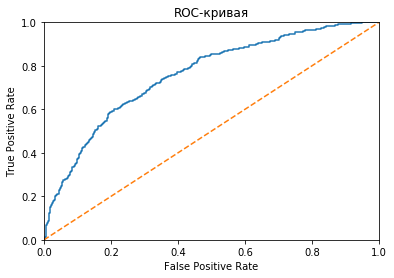

In [35]:
model_LR = LogisticRegression(random_state = 125, solver = 'liblinear')
model_LR.fit(features_train, target_train)
probabilities_one_valid_LR = model_LR.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_LR) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Для логистической регрессии расчитаем метрику AUC-ROC

In [36]:
auc_roc_LR = roc_auc_score(target_valid, probabilities_one_valid_LR)
auc_roc_LR

0.7586317967081824

Теперь построим ROC-кривую и рассчитаем метрику AUC-ROC для логистической регресии, сбалансировав классы:

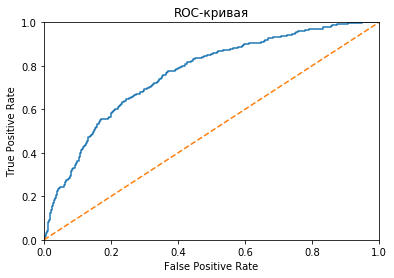

In [37]:
model_LR_balanced = LogisticRegression(random_state = 125,solver = 'liblinear', class_weight='balanced')
model_LR_balanced.fit(features_train, target_train)
probabilities_one_valid_LRB = model_LR_balanced.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_LRB) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [38]:
auc_roc_LRB = roc_auc_score(target_valid, probabilities_one_valid_LRB)
auc_roc_LRB

0.7635798063138539

Метрика немного увеличилась после того, как классы сбалансировались

Переходим к формированию сбалансированных выборок. Создадим функцию def upsample() для увеличения представленного класса в выборке:
- разделим обучающую выборку на положительные и отрицательные ответы. Объявим четыре переменные  
    - features_zeros — признаки объектов с ответом «0»
    - features_ones — признаки объектов с ответом «1»
    - target_zeros — целевой признак объектов, у которых ответы только «0»
    - target_ones — целевой признак объектов, у которых ответы только «1»
- так как положительных ответов мы имеем в 4 раза меньше, то увеличим их количество в 4 раза и создадим новую обущающую выборку
- перемешаем данные, так как если данные будут идти друг за другом - модели будет сложно обучиться

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [40]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(9588,)


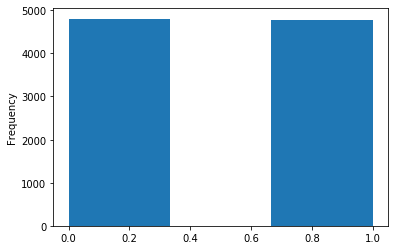

In [41]:
target_train_upsampled.plot(kind ='hist', bins=3)

Подсчитаем точность LogisticRegression на сбалансированной выборке:

In [42]:
model_LR_upsampled = LogisticRegression(random_state = 125,solver = 'liblinear', class_weight='balanced')
model_LR_upsampled.fit(features_train_upsampled, target_train_upsampled)
prediction_LR_upsampled = model_LR_upsampled.predict(features_valid)

print("Accuracy:", accuracy_score(target_valid, prediction_LR_upsampled))

Accuracy: 0.701


С помощью цикла определим наилучшие значения гиперпараметров (количество деревьев и глубина) для RandomForestClassifier на сбалансированной выборке

In [43]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 250, 25), desc="Est loop"):
    for depth in tqdm(range (1, 15, 2), desc="Depth loop", leave=False):
        model_RFC_upsampled = RandomForestClassifier(random_state=125, max_depth=depth, n_estimators=est, class_weight='balanced') 
        model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled) 
        prediction_RFC_upsampled = model_RFC_upsampled.predict(features_valid)
        f1 = f1_score(prediction_RFC_upsampled, target_valid)
        
        if f1 > best_result:
            best_result = f1_score(prediction_RFC_upsampled, target_valid)
            best_est = est
            best_depth = depth
            best_model = model_RFC_upsampled
            
print("F1-мера наилучшей модели:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)
print("Наилучшая модель:", best_model)


F1-мера наилучшей модели: 0.6286407766990291
Количество деревьев: 60
Максимальная глубина: 13
Наилучшая модель: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=None, oob_score=False,
                       random_state=125, verbose=0, warm_start=False)


Получили F1-меру наилучшей модели равную 0.63 с максимальной глубиной - 29 и количеством деревьев - 41. Теперь оценим точность этой модели:

In [44]:
model_RFC_upsampled = best_model
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
prediction_RFC = model_RFC.predict(features_valid)

print("Точность для RandomForestClassifier:", accuracy_score(target_valid, prediction_RFC))

Точность для RandomForestClassifier: 0.8255


Точность для модели LogisticRegression равна 0.7, для RandomForestClassifier (после подбора наилучших гиперпараметров) - 0.85.

Посмотрим на остальные характеристики качетсва:

LogisticRegression

In [45]:
model_LR_upsampled = LogisticRegression(random_state = 125,solver = 'liblinear', class_weight='balanced')
model_LR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LR_prediction_upsampled = model_LR_upsampled.predict(features_valid)

print("Полнота для логистической регрессии" , recall_score(target_valid, LR_prediction_upsampled))
print("Точность для логистической регрессии", precision_score(target_valid, LR_prediction_upsampled))
print("F1-мера для логистической регрессии", f1_score(target_valid, LR_prediction_upsampled))
print("AUC-ROC для логистической регрессии", roc_auc_score(target_valid, LR_prediction_upsampled))

Полнота для логистической регрессии 0.6842105263157895
Точность для логистической регрессии 0.3803191489361702
F1-мера для логистической регрессии 0.4888888888888888
AUC-ROC для логистической регрессии 0.6948233415396898


Значения полноты и F1 меры увеличились с 0.24 до 0.68 и с 0.33 до 0.48 соответсвенно. Немного снизилось значение точности и AUC-ROC метрики, но тем неменее значени AUC-ROC выше чем у случайной модели

RandomForestClassifier

In [46]:
model_RFC_upsampled = best_model
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)

print("Полнота для случайного леса" , recall_score(target_valid, RFC_prediction_upsampled))
print("Точность для случайного леса", precision_score(target_valid, RFC_prediction_upsampled))
print("F1-мера для случайного леса", f1_score(RFC_prediction_upsampled, target_valid))
print("AUC-ROC для случайного леса", roc_auc_score(target_valid, RFC_prediction_upsampled))

Полнота для случайного леса 0.6196172248803827
Точность для случайного леса 0.6379310344827587
F1-мера для случайного леса 0.6286407766990291
AUC-ROC для случайного леса 0.7633484354490409


Для случайного леса значения полноты и F1 меры увеличились с 0.46 до 0.61 и с 0.58 до 0.63 соответсвенно. Значение AUC-ROC достаточно высокое - 0.76

## Тестирование модели

In [47]:
test_model_RFC = RandomForestClassifier(random_state=125, n_estimators=100,max_depth= 14)
test_model_RFC.fit(features_train_upsampled, target_train_upsampled)
test_model_RFC_prediction = test_model_RFC.predict(features_test)

print("Полнота для дерева решений на тестовой выборке" , recall_score(target_test, test_model_RFC_prediction))
print("Точность для дерева решений на тестовой выборке", precision_score(target_test, test_model_RFC_prediction))
print("F1-мера для дерева решений на тестовой выборке", f1_score(target_test, test_model_RFC_prediction))
print("AUC-ROC для дерева решений на тестовой выборке", roc_auc_score(target_test, test_model_RFC_prediction))

Полнота для дерева решений на тестовой выборке 0.5862884160756501
Точность для дерева решений на тестовой выборке 0.6358974358974359
F1-мера для дерева решений на тестовой выборке 0.6100861008610086
AUC-ROC для дерева решений на тестовой выборке 0.7481220139985099


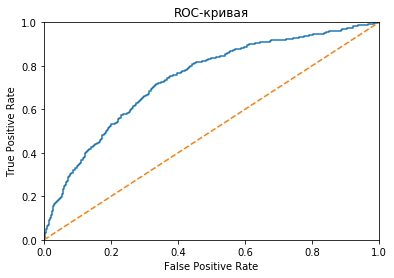

In [48]:
final_model_probabilities_one = model_LR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Протестировав модель, получили следующие показатели:
- Полнота - 0.59
- Точность - 0.64
- F1-мера - 0.61
- AUC-ROC метрика - 0.75

Модель с точность 59% предскажет уход клиента из банка, метрика F1 = 0.61, показатель 0.59 достигнут

In [49]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 250, 25), desc="Est loop"):
    for depth in tqdm(range (1, 15, 2), desc="Depth loop", leave=False):
        model_RFC = RandomForestClassifier(random_state=125, max_depth=depth, n_estimators=est) 
        model_RFC.fit(features_train, target_train) 
        prediction_RFC = model_RFC.predict(features_valid)
        f1 = f1_score(prediction_RFC, target_valid)
        
        if f1 > best_result:
            best_result = f1_score(prediction_RFC, target_valid)
            best_est = est
            best_depth = depth
            best_model = model_RFC
            
print("F1-мера наилучшей модели:", best_result)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)
print("Наилучшая модель:", best_model)


F1-мера наилучшей модели: 0.5840978593272171
Количество деревьев: 135
Максимальная глубина: 11
Наилучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=135,
                       n_jobs=None, oob_score=False, random_state=125,
                       verbose=0, warm_start=False)


In [50]:
test_model_RFC = best_model
test_model_RFC.fit(features_train, target_train)
test_model_RFC.fit(features_valid, target_valid)
test_model_RFC_prediction = test_model_RFC.predict(features_test)

print("Полнота для случайного леса на тестовой выборке" , recall_score(target_test, test_model_RFC_prediction))
print("Точность для случайного леса на тестовой выборке", precision_score(target_test, test_model_RFC_prediction))
print("F1-мера для случайного леса на тестовой выборке", f1_score(target_test, test_model_RFC_prediction))
print("AUC-ROC для случайного леса на тестовой выборке", roc_auc_score(target_test, test_model_RFC_prediction))

Полнота для случайного леса на тестовой выборке 0.39952718676122934
Точность для случайного леса на тестовой выборке 0.7222222222222222
F1-мера для случайного леса на тестовой выборке 0.5144596651445967
AUC-ROC для случайного леса на тестовой выборке 0.6791548425879704


<a class="anchor" id="31-bullet">

In [65]:
# объединяем выборки
features_ = pd.concat([features_train, features_valid])
target_ = pd.concat([target_train, target_valid])

In [66]:
# обучаем модель (насколько я понял лучше при подборе была модель со взвешиванием классов)
m_ = RandomForestClassifier(random_state=125, max_depth=7, n_estimators=250, class_weight='balanced') 
m_.fit(features_, target_)
test_model_RFC_prediction = m_.predict(features_test)

In [67]:
# смотрим метрики
print("Полнота для случайного леса на тестовой выборке" , recall_score(target_test, test_model_RFC_prediction))
print("Точность для случайного леса на тестовой выборке", precision_score(target_test, test_model_RFC_prediction))
print("F1-мера для случайного леса на тестовой выборке", f1_score(target_test, test_model_RFC_prediction))
print("AUC-ROC для случайного леса на тестовой выборке", roc_auc_score(target_test, test_model_RFC_prediction))

Полнота для случайного леса на тестовой выборке 0.6855791962174941
Точность для случайного леса на тестовой выборке 0.5461393596986818
F1-мера для случайного леса на тестовой выборке 0.6079664570230608
AUC-ROC для случайного леса на тестовой выборке 0.7663786913237122


F1 при таком способе получилась ~0.608. Выше чем недо и чуть меньше чем при обычном тестировании, но можно быть уверенным что модель получилась стабильнее и более о общей

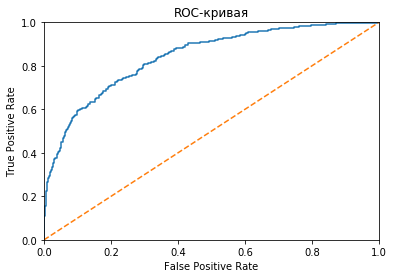

In [51]:
final_model_probabilities_one = test_model_RFC.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [52]:
import numpy as np

In [53]:
y = beta_ohe['Exited']
X = beta_ohe.drop('Exited', axis=1)

In [54]:
learning = {'train_size': [],
           'train_error': [],
           'test_error': []}
for size in tqdm(np.linspace(0.05, 0.9, 20), desc="Test size loop"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=12345)
    # overfitted model
    m = RandomForestClassifier(random_state=125, max_depth=29, n_estimators=135)
    
    # like norm model
    #m = RandomForestClassifier(random_state=125, max_depth=7, n_estimators=210, class_weight='balanced')
    m.fit(X_train, y_train)
    test_score = accuracy_score(y_test, m.predict(X_test))
    train_score = accuracy_score(y_train, m.predict(X_train))
    learning['train_size'] += [1 - size]
    learning['test_error'] += [1 - test_score]
    learning['train_error'] += [1 - train_score]

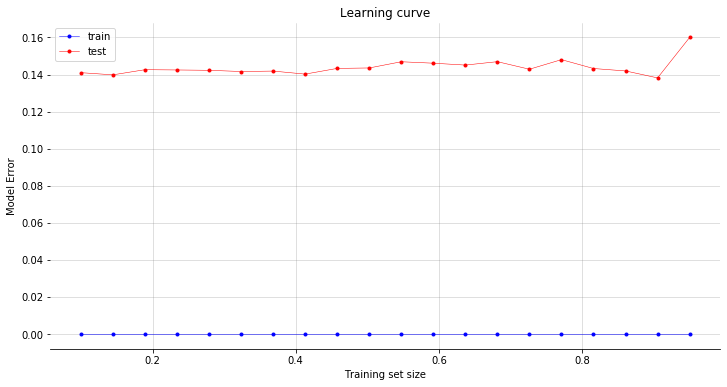

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(learning['train_size'], learning['train_error'], 
        color='blue', marker='o', markersize=3, linewidth=0.5, label="train")
ax.plot(learning['train_size'], learning['test_error'], 
        color='red', marker='o', markersize=3, linewidth=0.5, label="test")
ax.set_title("Learning curve")
ax.set_xlabel("Training set size")
ax.set_ylabel("Model Error")
ax.legend()
ax.grid(color='grey', alpha=0.5, linewidth=0.5)
d = {'left': False, 'right': False, 'top': False, 'bottom': True}
for spine in ax.spines:
    ax.spines[spine].set_visible(d[spine])
fig.show()

## Общий вывод

#### Подготовили датасет к расчетам и анализу:
- пропущенные значения в столбце Tenure (сколько лет человек является клиентом банка) были заменены на нули
- данные в столбцах RowNumber, CustomerId, Surname не несут значимой ценности для обучения модели , а могли даже помешать            дальнейшему анализу, поэтому были удалены
- преобразовали категориальные признаки столбцов Geography и Gender в численные с помощью техники OHE. Столбец Geography              содержал 3 класса, Gender_Male - 2 класса, после преобразования техникой OHE мы получили 2 и 1 столбец соответственно, избежав        дами-ловушки. В новом датафрейме получилось 12 столбцов
     
     
#### Разделили датасет на тестовую, валидационную и обучающую выборки, масштабировали признаки и изучили задачи для моделей LogisticRegression и RandomForestClassifier с дисбалансом:
- Точность для LogisticRegression: 0.8 
- F1 для LogisticRegression: 0.33
- Точность для RandomForestClassifier: 0.86
- F1 для RandomForestClassifier: 0.59


#### Сделали веса классов сбалансированными, добавив к моделям аргумент class_weight='balanced' и получили значение точности и F1 меры:
- Значение F1 меры для LogisticRegression увеличилось с 0.33 до 0.49, но accuracy снизилось с 0.8 до 0.7
- Для RandomForestClassifier значение accuracy осталось прежним - 0.86, а F1 мера также увеличилась с 0.59 до 0.6
    
    
#### Сформировали сбалансированные выборки. Была создана функцию def upsample() для увеличения представленного класса в выборке:
- разделим обучающую выборку на положительные и отрицательные ответы
- увеличили количество положительных ответов в 4 раза и создали новую обущающую выборку
- перемешали данные, так как если данные будут идти друг за другом - модели будет сложно обучиться
- Для логистической регрессии значения полноты и F1 меры увеличились с 0.24 до 0.68 и с 0.33 до 0.48 соответсвенно. Немного снизилось значение точности и AUC-ROC метрики, но тем неменее значени AUC-ROC выше чем у случайной модели
- Для случайного леса значения полноты и F1 меры увеличились с 0.46 до 0.6 и с 0.59 до 0.62 соответсвенно. Значение AUC-ROC достаточно высокое - 0.75
    
    
#### Проведено тестирование модели:
- модель достигла заданой метрики F1 = 0.61 и показывает адекватные результаты
- с точность 59% предскажет уход клиента из банка
- показатель точности равен 0.64

Для улучшения модели следует использовать данные, отражающие отношения клиента с банком в динамике.